In [47]:
%matplotlib inline


# DCGAN  for Skin Cancer

#### Tomer Eldor, Minerva, Nov 2018
------------------------------


This is an implementation of a Deep Convolutional Generative Adversarial Network, trained to generate fake images of skin cancer tumors. 
Data is a collection of dermatoscopic images of pigmented cancer lesions.
Data downloaded from https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/home, original source:
    https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T
    Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 (2018). doi: 10.1038/sdata.2018.161

I believed such efforts can help in the way of:
1. Data augmentation: help in augments medical datasets of such sort to help in other deep learning tasks. For example, this could be converted into a conditional DCGAN based on the type of lesion which could generate lesions based on an input of a class, or based on an input of a healthy skin patch(!).
2. Later applications like Anomaly detection which can be applied to cancerous cells anomalies, such as the application in AnoGAN: https://github.com/LeeDoYup/AnoGAN.


This DCGAN is based on the following sources:
* Idea: DCGAN original paper: "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks", Alec Radford, Luke Metz, and Soumith Chintala (2016).
1. Pytorch's Tutorial for DCGAN: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
2. Diego Gomez Mosquera's impelmentation (referenced in class: https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f
3. Manual Modifications, changed architecture and size,
    Used this convolutions calcualtor to verify correct acrhitecture: 
    http://mohanadkaleia.com/convcalc/
4. Improving Training tips from class resources:
    * https://arxiv.org/pdf/1606.03498.pdf
    * https://github.com/soumith/ganhacks
5. Data Source: Downloaded from Kaggle - https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000





# Installations and Imports
------------------------------

In [2]:
# Set Number of GPUs available. Use 0 for CPU mode.

# Imports 
from __future__ import print_function
import argparse
import os
import random
import pandas as pd
import numpy as np
from glob import glob
import PIL
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets 
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
N_GPU = 0

# Random Seed (for reproducing)
random_seed = 100
random.seed(random_seed)
torch.manual_seed(random_seed)

## Setting Hyperparameters and Inputs


Below the hyperparameters and important inputs for the model are defined.

In [30]:
# SETTING INPUTS HYPERPARAMETERS
N_WORKERS = 4 # Number of workers for dataloader
BATCH_SIZE = 128 # Batch size during training. DCGAN Paper (Radford et al) used minibatches of size 128.
IMAGE_SIZE = 32 # Spatial size to resize images to using transformer, as square (image_size = height = width)
N_G_Features = 32 # Size of depth of feature maps in generator
N_D_Features = 32 # Size of depth of feature maps propagated in the discriminator
N_Color_Channels = 3 # Number of channels in the training images (Color = RGB = 3)
N_Z_vec = 100 # Size of z latent vector (i.e. size of generator input)
device = "cpu" # currently working with CPU. if GPU change to that. 

## Data

In [5]:
# Download the data from:
# https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000
# Or try to use the command line (didn't work for me though)
# !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Converting the Metadata CSV to a Pandas Dataset, to view, get a sense of the data, and be able to use later if we want (will come in handy in future extensions mostly, and if wanted to incorporate image with metadata for prediction and classification purposes.

In [6]:
### CONVERT CSV INTO PANDAS DATASET ###
# *Ended up not using it in this round. It would be helpful for: the custom dataset loader class (attached at end), 
# classification of types of cancer, and usage of metadata about patients in the images for classification / prediction

# Set dir paths
base_skin_dir = os.path.join('.', 'data/skincancer_ham/')
df_csv_images = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Human Readable Label Names
lesion_type_dict = { 'nv': 'Melanocytic nevi', 'mel': 'Melanoma', 
                    'bkl': 'Benign keratosis-like lesions ',
                    'bcc': 'Basal cell carcinoma', 'akiec': 'Actinic keratoses',
                    'vasc': 'Vascular lesions','df': 'Dermatofibroma' }

# Create some new columns (path to image, human-readable name) and review them
df_csv_images['celltype_name'] = df_csv_images['dx'].map(lesion_type_dict.get) 
df_csv_images['class'] = pd.Categorical(df_csv_images['celltype_name']).codes

# Currently working with a subset of the data, where the file name ends with a small number than 29306
df_images = df_csv_images[df_csv_images.image_id < 'ISIC_0029306']
print(df_images.shape)
df_images.sample(3)

(5000, 9)


,lesion_id,image_id,dx,dx_type,age,sex,localization,celltype_name,class
6829,HAM_0006108,ISIC_0024697,nv,histo,15.0,male,neck,Melanocytic nevi,4
478,HAM_0006945,ISIC_0026044,bkl,histo,60.0,female,lower extremity,Benign keratosis-like lesions,2
564,HAM_0006595,ISIC_0028223,bkl,histo,55.0,female,face,Benign keratosis-like lesions,2


Each image of a skin cancer instance has extra infromation - including label (type of cancer cell), sex and age of the patient, which for now is not used, but later might be used as a condition to generate different types of cells as a conditional DCGAN.

In [7]:
### BUILD DATASET AND DATALOADER FROM IMAGES FOLDER

# defining folder paths
base_root = '/Volumes/GoogleDrive/My Drive/Colab Notebooks/'
csv_filepath = base_root + 'data/skincancer_ham/HAM10000_metadata.csv'
images_dirpath = base_root + 'data/skincancer_ham/'


# First, define trasnformations onto the origianl large JPG images
compose_transform = transforms.Compose([# resize to 32*32 pixels
                                        transforms.Resize(32), 
                                        # Crop to the center of the image
                                        transforms.CenterCrop(IMAGE_SIZE), 
                                        # convert to tensor format for PyTorch
                                        transforms.ToTensor(), 
                                        # normalize pixel values in each channel around mean of 0.5
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
                                        ])

                                       
# Loading images into pytorch dataset object using ImageFolder Class 
# * ImageFolder is a general class you can use to build a pytorch dataset from 
# a folder with images, where images are nested inside folders with names of labels.
#   * Initially I created my own Pytorch Dataset Class (attached at bottom 
#   for future reference), but later I found ImageFolder to exist and work.
dataset = torchvision.datasets.ImageFolder(root = images_dirpath, 
                                           transform = compose_transform)

# We only use one general class of all skin cancer types found in that data. 
# Print the classes found:
print("Classes:", dataset.classes)

# Build a PyTorch DataLoader Class. This class is an iterator which sampels batches
# from the data, allows to iterate through it, integrates perfectly 
# within PyTorch and can allocate to multiple workers in GPU. 
# We use it to iterate through batches later on.
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=BATCH_SIZE,
                                         shuffle=True, 
                                         num_workers=N_WORKERS)

# Check how many Batches do we have and show result
num_batches = len(dataloader)
print("num_batches:", num_batches)

Classes: ['skin_cancer']
num_batches: 40


#### Visaulize some input images examples

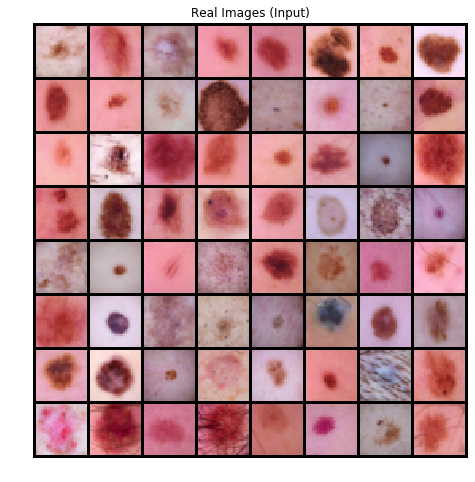

In [9]:
# Visualize input image examples
def show_images_grid(images_batch):
    images_gridsize = 8 
    plt.figure(figsize=(images_gridsize,images_gridsize)) # initialize a figure
    plt.axis("off") # remove axes
    plt.title("Real Images (Input)") # add title
    # make a grid of images with padding and visualize it. normalize normalizes pixel values in RGB
    image_grid = np.transpose(vutils.make_grid(images_batch[0][:images_gridsize**2], padding=2, normalize=True))
    plt.imshow(image_grid) 

images_batch = next(iter(dataloader)) # get a batch of sample input images
show_images_grid(images_batch)

# Building the GAN Architecture
--------------

Now I will build the GAN itself;
The generator, discriminator, weigth initialization, and loss functions.
After that, we could start the training loop.




### Discriminator

The Discriminator is a convolutional classification network. It takes in as input 
either a real or fake image, and ouptuts a probability of "realness" of that image
between 0 and 1.
Below is the Convolutional Discriminator architecture. 
This one takes as input an image of size 3*32*32 (color channels*image_size*image_size) 
and through a series of 4 convolutional layers outputs a probability.
This architecture of 4 convolutional layers, each with a stride convolution 
(rather than pooling as downsampling, as was recommended in Radford et al in the DCGAN paper,
since that way the network can learn its own pooling function).
where each convolutional layer except the last one also has: stride=2, padding=1, 
doubles the number  of kernel channels. That way, the depth doubles (number of D features) 
while height*width of layer halves because of the stride=2). Then I apply
Batch Normalization and use Leaky ReLU as the activation function 
(as recommended by the DCGAN paper for helping with better gradient flow - Radford et al). 
As the Discriminator initially was "too good" (loss dropped massively and didn't let G improve),
I added a dropout layer and tuned its value through some experiments.



#### Discriminator Code



In [23]:
class Discriminator(nn.Module):
    """
    Deep Convolutional Discriminator Class. 
    Takes an image (either real or fake), and through convolutions outputs a probability /
    degree of belief of that image being real (between 0=fake and 1=real).
    I use one-sided smooth labeling, where real images have a fuzzy label close to 1 
    (decreasing exponentially from 1 down) in training (passing the real images.
    """
    def __init__(self, N_GPU):
        """
        Initialize the architecture of the Discriminator NetworkΩ.
        The architecture basically mirorrs the Generator's network.
        Added Batch Normalization, Dropout Layers, LeakyReLU Activation Layers - 
        According to reommendations at DCGAN Paper (Radford et al) and GAN Hacks.
        """
        # super() ensures inheritance and that calling the class cass next method in line
        # in the method resolution order, and no infinite loops
        super(Discriminator, self).__init__() 
        # Now build the architecture!
        self.architecture = nn.Sequential(
            #
            # LAYER 1 Convolution
            # input is (N_Color_Channels) x 32 x 32. 
            # Strided convolution: The DCGAN paper mentions strided convolution is preferable to 
            # pooling to downsample because it lets the network learn its own pooling function. 
            nn.Conv2d(in_channels = N_Color_Channels, # start with noise Z vector
                      out_channels = N_D_Features, # desired n_filters for output size
                      kernel_size = 4, # size of filter
                      stride = 2, # stride of each filter convoluting over image * recommended over pooling
                      padding = 1, # padding of 1 at edges
                      bias = False), # no bias term added in this implementation
            # DCGAN Paper (Radford et al) recommend Leaky ReLU (0.2) at all discriminator layers
            # as it promotes healther gradient flow
            nn.LeakyReLU(0.2, inplace=True), 
            # state size. (N_D_Features) x 16 x 16
            
            ## LAYER 2 Convolution
            nn.Conv2d(in_channels = N_D_Features, # last output
                      out_channels = 2*N_D_Features, # desired num kernels channels
                      kernel_size = 4, # size of filter
                      stride = 2, # stride of each filter 
                      padding = 1, # padding at edges
                      bias = False), # no bias
            # batch normalization as recommended by Radford et al for improving gradient flow behavior
            nn.BatchNorm2d(2*N_D_Features), # perform batch normalization on the n_kernels of output
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (N_D_Features*2)  x 8 x 8
            
            ## LAYER 3 Convolution
            nn.Conv2d(in_channels = 2*N_D_Features, # last output
                      out_channels = 4*N_D_Features, # desired num kernels channels
                      kernel_size = 4, # size of filter
                      stride = 2, # stride of each filter 
                      padding = 1, # padding at edges
                      bias = False), # no bias
            nn.BatchNorm2d(4*N_D_Features),
            nn.LeakyReLU(0.2, inplace=True),
            ## **Adding DROPOUT LAYER to "dumb" out Discriminator which was "too good"
            nn.Dropout2d(0.5),
            # state size. (N_D_Features*4) x 4 x 4
            
            ## LAYER 4 Convolution
            nn.Conv2d(in_channels = 4*N_D_Features, 
                      out_channels = 1, # last fully layer of convolution - output 1D
                      kernel_size=4, 
                      stride=1, 
                      padding=0, 
                      bias=False),
            nn.Sigmoid() # 1D output activation 
        )

    def forward(self, input):
        """
        Propagates an input (image) through the NN architecture 
        until outputting a label prediction (realness level between 0-1)
        """
        # nn.Sequential propoagates through the given order of layers when called upon
        return self.architecture(input) 


In [22]:
# custom weights initialization called on netG and netD
def initialize_weights(model):
    """
    Function that initialized weights of convolutional layers and for batch-normalization.
    Radford et al specify that all model weights shall be sampled randomly from a Normal 
    distribution with mean=0 and std=0.2. This function will be used also for the Generator.
    This function should be applied to the models (using .apply(func) so that it iterates every class) 
    right after initializating the model.
    Arguments:
        model: an initialized model (Discriminator or Generator Network)
    Outputs:
        changes model in place to have weights initialized by that distribution
    """
    # check class type by name
    classname = model.__class__.__name__ # get name of class layer
    # if class has convolutional in its name:
    if classname.find('Conv') != -1: 
        # Initialize random weights for convolutional / deconvolutional layers
        # sampled from a normal distribution around 0
        nn.init.normal_(model.weight.data, mean=0.0, std=0.02) 
    # if class has Batch Normalization in its name:
    elif classname.find('BatchNorm') != -1:
        # Initialize random weights for BatchNorm sampled from a normal distribution around 1
        nn.init.normal_(model.weight.data, mean=1.0, std=0.02)
        nn.init.constant_(model.bias.data, 0) # biases of 0

Instantiate the discriminator network and weights. 

Print the model structure for easy viewing of the model architecture.

In [25]:
## INITIALIZING THE NETWORK
# Create the Discriminator onto the GPU if exist or cpu (from PyTorch tutorial)
netD = Discriminator()#.to(device)

# Initialize all weights randomly from normal dist
netD.apply(initialize_weights)

# Print the model
print(netD)

Discriminator(
  (architecture): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Dropout2d(p=0.3)
    (9): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): Sigmoid()
  )
)


### Generator

The Generator takes as input a random noise vector and learns 
to use its deconvolutions to transform it into an output similar
to the real data - here a 3 x 32 x 32 image 
(RGB 3 color channels x Image_Size x Image_Size).
This architecture mostly mirrors the Discriminator's convolutions.
I use 4 layers with a strided 2d Deconvolutions (ConvTranspose2d, stride=2), 
each doubling the output width x height, while halving the number of 
kernels (input channels) and eventually outputting a 3 x 32 x 32 output.
The architecture is modified based on the original architecture from the
DCGAN Paper (2016) by Radford et al (there was for an image sized 3x64x64).
As Radford et al (DCGAN Paper, 2016) recommmend, each deconvolution is 
followed by a Batch Noramlization layer.
The final layer's output has a tanh activation function so that the
values of the data range between [-1,1]

#### Generator Code
Two cells down will print the precise architecture with sizes 
for convenience of reading (and verifying) architecture.

In [26]:
# Generator Code

class Generator(nn.Module):
    """
    Convolutional Generator Class. 
    Takes in a Z noise vector as input, propogates it through a series of deconvolutions 
    and outputs a (fake) images of same size as real images (3 channels * image_size * image_size)
    """
    def __init__(self):
        """
        Initialize the architecture of the Network.
        The architecture basically mirorrs the Discriminator network.
        Added Batch Normalization, Dropout Layers, ReLU Activation Layers.
        """
        super(Generator, self).__init__() # delegates methods to parent
        self.architecture = nn.Sequential(
            
            ### Layer 1 
            # input is Z, going into a deconvolution 
            nn.ConvTranspose2d(in_channels=N_Z_vec, # start with noise Z vector
                               out_channels=4*N_G_Features, # desired n_filters for output size
                               kernel_size=4, # size of filter
                               stride=1, # stride of filter convoluting over image
                               padding=0, # no padding at edges
                               bias=False), # no bias term added in this implementation
            nn.BatchNorm2d(4*N_G_Features),  # batch normalization at output channels
            nn.ReLU(True),  # activation layer: ReLU
            # DROPOUT for improving training (smaller than D, to increase G's performance)
            nn.Dropout2d(0.2), 
            # state size. (N_G_Features*4) x 4 x 4
            
            ### Layer 2 deconvolution 
            nn.ConvTranspose2d(in_channels=4*N_G_Features, # start with last output n of channels
                               out_channels=2*N_G_Features, # n_kernels for desired output size
                               kernel_size=4, # size of each kernel
                               stride=2, # stride of kernel over image
                               padding=1, # pad of 1 
                               bias=False), # no bias term added in this implementation
            nn.BatchNorm2d(2*N_G_Features), # Batch Noramlization
            nn.ReLU(True), # ReLU
            # state size. (N_G_Features*2) x 8 x 8
            
            ### Layer 3 deconvolution 
            nn.ConvTranspose2d(in_channels=2*N_G_Features, # start with last output n of channels
                               out_channels=N_G_Features, # n_kernels for desired output size
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.BatchNorm2d(N_G_Features), # Batch Noramlization
            nn.ReLU(True), # ReLU
            # state size. (N_G_Features) x 16 x 16
            
            ### Layer 4 deconvolution
            nn.ConvTranspose2d(in_channels=N_G_Features, 
                               out_channels=N_Color_Channels, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            # Last activation layer (recommended as Tanh)
            nn.Tanh()
            # state size. (N_Color_Channels) x 32 x 32
        )

        
        
    def forward(self, input):
        """ 
        Forward propagates an input through the architecture
        Given a Z vector, the Net will output a fake image of N*Color_Channels*32*32 (Image_Size)
        Returns: a deconvoluted fake image
        """
        return self.architecture(input) # propagates input through architecture in main

Instantiate the generator and weights. 

Print the model structure for easy viewing of the model architecture.

In [27]:
# Create the generator
netG = Generator()#.to(device) # can specify to which CPU/GPU this goes

# Apply the initialize_weights function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(initialize_weights)

# Print the model
print(netG)

Generator(
  (architecture): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Dropout2d(p=0.2)
    (4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): Tanh()
  )
)


---------------------
### Set Up Loss Function and Label Smoothing

The loss function used for both networks is the Binary Cross Entropy loss (BCELoss) function. 
This function balances two long losses, which we can specify which y input is used (later in the training loop).
In this case, it can balance the log of both the discriminator for real images $log(D(x))$ 
(multiplied by the y label, should be 1 if real), 
and the discriminator's judgement of the generator $log(1-D(G(z)))$ (multiplied by $(1 - y_n)$ 1-label, 
label should be 1 if real, so term would be 0 if the generator's output is classified as real.
Thus should arrive at balanced loss between them.

Real label is 1 and fake label is 0. 
However, Salimans, Goodfellow, et al. *("Improved Techniques for Training GANs", 2016)*, 
https://arxiv.org/pdf/1606.03498.pdf
recommend using one-sided soft / smoothed labels in training (metnioned also in other sources), meaning
that the real labels (`1`) wouldn't be actually precisely `1.00`, but close to it (e.g., `0.9`).
That way the discriminator is less certain about images and it resembels more its outputted predictions.
Therefore, I make the real label be instantiated every time sampling from an exponential distribution approaching 1
and decaying exponentially downards towards 0 (mostly vanishing around 0.5).



example real label:  0.9744818274909423


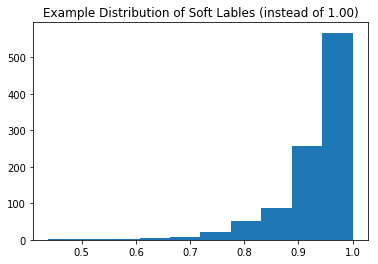

In [45]:
# Initialize Loss function as BCELoss
loss_function = nn.BCELoss()

# LABEL SMOOTHING
def real_label():
    """
    Generates a "smooth" "real" label: close to 1, 
    but with exponential decay towards 0 (yet always positice)
    """
    return float(abs(1 - np.random.standard_exponential(1)/15))
real_label = real_label()
fake_label = 0

# Verifying that this distribution is what we want: 
# we want numbers that are mostly close to one, so we want a noise that is mostly 
# tiny and exponensially decays, until there are almost no noise close to 1 
# (but some small number exist, since that is also good for training)
print("example real label: ", real_label)
example_distribution = np.abs(1-np.random.standard_exponential(1000)/15)
plt.hist(example_distribution)
plt.title("Example Distribution of Soft Lables (instead of 1.00)")
plt.show()


### Set Up Optimizers
Set up the two optimizers for D and G. Radford et al in the DCGAN paper
recommended to use Adam Optimizers for both, with learning rate 0.0002 and Beta1 = 0.5. 


In [32]:

# Setup Adam optimizers for both G and D
# * Tried with SGD for the Discriminator but that didn't work well
# Setting Beta1 hyperparam for Adam optimizers. In Radford et al (DCGAN Paper),
# Authors recommended to set Beta1 to 0.5 and Learning rate to 0.0002

LEARN_RATE = 0.0002
BETA1 = 0.5 

optimizerD = optim.Adam(netD.parameters(), lr=LEARN_RATE, betas=(BETA1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LEARN_RATE, betas=(BETA1, 0.999))


# Training the GAN
----------------------------

Now that both D and G are defined nad instantiated with weights and optimizers,
we can start training the GAN.

GAN training consists of epochs, where in each, we first train the discriminator 
on both real and fake images, and then go to update the generator with the backpropogated
gradients from the loss function of the discriminator's loss for the fake images.

Training GANs is often unstable and for that reason I followed:
(1) Tips from Radford et al (DCGAN Paper, 2016); and 
(2) Tips and Tricks from Gan Hacks covered in previous session:  <https://github.com/soumith/ganhacks>

Specifically, the practices followed here include:
* Using different mini-batches separately for real and fake images
* Modify G’s loss function to **maximize  $log D(G(z))$** instead of **minimizing $(log 1-D)$**. 
* During training, paid close attention to the progression of the loss functions and when were too unstable, changed paramters. For example, the dsicriminator network was doing "too well", so that loss decreased to 0, and made it too hard for the Generator, therefore I added a dropout layer to the discriminator network to make it tougher for D and thus balance more between G and D.

Training is composed of the following steps:

#### 1. Training the Discriminator
Here we want the discriminator to corretly classify real/fake inputs. 
Implementing seperate real/fake batches suggestion, here we will calculate the loss function in two steps:
1. Sample a batch of *real* images and feed it forward throught the discriminator, calculate the loss $log(D(x))$ and save the backpropagation gradients. 
2. Generate a same sized batch of fake images using the current Generator network, feed it forward through the discriminator, calculate the loss $log(1-D(G(z)))$, and save the backpropagation gradients. 
3. Add up both gradients (from the real batch and fake batch) as total gradients (which balances telling the Generator where to step in the space both towards better classification of real and fake images).
4. Update the Discriminator's parameters using those gradients through a step through Adam optimizer.

#### 2. Training the Generator

We want to maximize $log(D(G(z)))$ - meaning for the Discriminator to classify G's outputs as closest to "real" as possible.
This is achieved by:
1. Previously, we generated fake images by forward passing Z random noise vectors through G and generating a batch of fake images. We already fed those through the Discriminator and saved the loss.
2. We compute G's loss using real labels as GT (this allows using the
$log(x)$ part of the BCELoss (rather than the $log(1-x)$ part.
3. Updating the Generator's parameters through a step of its Adam optimizer. 


#### Training Epochs and Reporting Results
After each epoch the following statistics are reported:
-  **Loss_$D$** - Loss of the discriminator (sum of losses for all real and fake batches).
-  **Loss_$G$** - Loss of the generator
-  **$D(x)$** - average classification output of the discriminator
   for the real batch. (This should decrease as G improves).
-  **$D(G(z))$** - average classification output of the discriminator for the fake batch. Here there are two outputs: [before D is updated / after D is updated]

The losses are saved and would later be visualized, as well as the fake images output from G.

-
 *I have ran this for 150 epochs on my local machine and the results looked decent. I have tried to run this on a GPU using Google Colab, but every time it disconnects it takes another 10-15 minutes of work to authenticate and set it up again, and encountered multiple environment errors that change when I change the code. Therefore, I worked mainly on my local machine, and luckily the networks was sufficiently sparse for an epoch to run in 4 minutes so that I could see if it works more easily on my own machine during building and training.*


In [62]:
# Training Loop
from datetime import datetime

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Create fixed noise vectors to visualize how G transforms them into images at each epoch
# taking 64 noise vectors for visualizing 8x8 images
fixed_noise = torch.randn(64, N_Z_vec, 1, 1, device=device)

print(datetime.now(), " – Starting Training...")

NUM_EPOCHS = 150 ### *** This has been defined above at top but redefinining it here for ease

# Each epoch will do a full training step for both D and G
# This training algorithm is mostly taken from PyTorch Tutorial Implementation
# following the DCGAN Paper, with some modifications. 
for epoch in range(NUM_EPOCHS):
    # For each batch in the dataloader, iterate through images and i
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # 1. Update Discriminator
        ###########################
        
        ## 1.1. REALs: Train D with a batch of only REAL images
        netD.zero_grad() # instantiate with zero gradients 
        # Format batch
        real_batch = data[0] # take real image batch as input 
        # * If in GPU, might need to replace with data[0].to(device)
        b_size = real_batch.size(0) # grab size lenth
        label = torch.full((b_size,), real_label) # create tensor of labels
        # Forward pass real batch through D
        output = netD(real_batch).view(-1)
        
        # Calculate loss on batch of real images
        err_D_real = loss_function(output, label)
        # Calculate gradients for D in backward pass
        err_D_real.backward()
        D_x = output.mean().item()

        ## 1.2. FAKEs: Train D with batch of only FAKE images
        # Generate batch of latent vectors for the Generator 
        # from a normal gaussian distribution as recommended in Gan Hacks
        noise = torch.randn(b_size, N_Z_vec, 1, 1)
        # Generate fake image batch with G
        fake = netG(noise) # feeds noise vector through the G net
        label.fill_(fake_label) # the label tensor is replaced with fake labels of same size (0's) 
        # Forward Pass the fake images through D to classify and save results
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        err_D_fake = loss_function(output, label)
        # Calculate the gradients for this batch
        err_D_fake.backward()
        # Calculate Discriminator's mean result D(G(z)) for reporting 
        D_G_z1 = output.mean().item() 
        # Add the gradients from the REAL and FAKE batches together
        err_D = err_D_real + err_D_fake
        # Update D's parameters with Adam optimizer
        optimizerD.step()

        ############################
        # 2. Update Generator 
        ###########################
        netG.zero_grad() # instantiate gradients with 0's
        label.fill_(real_label) # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        err_G = loss_function(output, label)
        # Calculate gradients for G
        err_G.backward() # error from backward pass 
        # Discriminator's classification for G after update for reporting results
        D_G_z2 = output.mean().item() 
        # Update G's parameters with Adam optimizer
        optimizerG.step()
        
        # Every 50 images in the batch (if there are more, in this case not),
        # Print training stats
        if i % 50 == 0:
            print("\n",datetime.now())
            print('Epoch [%d/%d] Image [%d/%d] \t Loss_D: %.4f \t Loss_G: %.4f\t \nD(x) (D output for real imgs): %.4f \t D(G(z)) (D output for fake imgs): %.4f / %.4f'
                  % (epoch, NUM_EPOCHS, i, len(dataloader),
                     err_D.item(), err_G.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(err_G.item())
        D_losses.append(err_D.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise at 500 iters or at end
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

print("\n\n-----DONE!------",datetime.now())

2018-11-13 01:52:53.523713  – Starting Training...

 2018-11-13 01:53:01.469543
Epoch [0/150] Image [0/40] 	 Loss_D: 1.1222 	 Loss_G: 0.9956	 
D(x) (D output for real imgs): 0.3420 	 D(G(z)) (D output for fake imgs): 0.0111 / 0.4159

 2018-11-13 01:54:06.491996
Epoch [1/150] Image [0/40] 	 Loss_D: 0.5665 	 Loss_G: 2.6774	 
D(x) (D output for real imgs): 0.7933 	 D(G(z)) (D output for fake imgs): 0.0845 / 0.0670

 2018-11-13 01:55:05.376521
Epoch [2/150] Image [0/40] 	 Loss_D: 0.6896 	 Loss_G: 3.5101	 
D(x) (D output for real imgs): 0.8788 	 D(G(z)) (D output for fake imgs): 0.2061 / 0.0246

 2018-11-13 01:56:03.309502
Epoch [3/150] Image [0/40] 	 Loss_D: 0.9380 	 Loss_G: 0.9686	 
D(x) (D output for real imgs): 0.4569 	 D(G(z)) (D output for fake imgs): 0.0635 / 0.4034

 2018-11-13 01:56:57.680807
Epoch [4/150] Image [0/40] 	 Loss_D: 0.9710 	 Loss_G: 2.4586	 
D(x) (D output for real imgs): 0.7883 	 D(G(z)) (D output for fake imgs): 0.3519 / 0.0887

 2018-11-13 01:57:51.470300
Epoch [5/1


 2018-11-13 02:31:37.430104
Epoch [45/150] Image [0/40] 	 Loss_D: 1.4033 	 Loss_G: 1.4060	 
D(x) (D output for real imgs): 0.5183 	 D(G(z)) (D output for fake imgs): 0.4655 / 0.2372

 2018-11-13 02:32:26.533742
Epoch [46/150] Image [0/40] 	 Loss_D: 1.1754 	 Loss_G: 1.1191	 
D(x) (D output for real imgs): 0.5036 	 D(G(z)) (D output for fake imgs): 0.3367 / 0.3225

 2018-11-13 02:33:11.030119
Epoch [47/150] Image [0/40] 	 Loss_D: 1.4529 	 Loss_G: 1.0057	 
D(x) (D output for real imgs): 0.5818 	 D(G(z)) (D output for fake imgs): 0.5370 / 0.3670

 2018-11-13 02:33:55.863782
Epoch [48/150] Image [0/40] 	 Loss_D: 1.4041 	 Loss_G: 0.8590	 
D(x) (D output for real imgs): 0.3428 	 D(G(z)) (D output for fake imgs): 0.2884 / 0.4370

 2018-11-13 02:34:40.673867
Epoch [49/150] Image [0/40] 	 Loss_D: 1.2375 	 Loss_G: 1.1144	 
D(x) (D output for real imgs): 0.4917 	 D(G(z)) (D output for fake imgs): 0.3656 / 0.3158

 2018-11-13 02:35:25.093329
Epoch [50/150] Image [0/40] 	 Loss_D: 1.5006 	 Loss_G: 0


 2018-11-13 03:05:18.411727
Epoch [90/150] Image [0/40] 	 Loss_D: 1.4094 	 Loss_G: 0.9139	 
D(x) (D output for real imgs): 0.5312 	 D(G(z)) (D output for fake imgs): 0.5033 / 0.3915

 2018-11-13 03:06:02.395343
Epoch [91/150] Image [0/40] 	 Loss_D: 1.4181 	 Loss_G: 0.8448	 
D(x) (D output for real imgs): 0.3345 	 D(G(z)) (D output for fake imgs): 0.2977 / 0.4282

 2018-11-13 03:06:46.527090
Epoch [92/150] Image [0/40] 	 Loss_D: 1.3269 	 Loss_G: 0.9566	 
D(x) (D output for real imgs): 0.4225 	 D(G(z)) (D output for fake imgs): 0.3584 / 0.3777

 2018-11-13 03:07:31.922447
Epoch [93/150] Image [0/40] 	 Loss_D: 1.3169 	 Loss_G: 0.9579	 
D(x) (D output for real imgs): 0.3978 	 D(G(z)) (D output for fake imgs): 0.3303 / 0.3784

 2018-11-13 03:08:16.214886
Epoch [94/150] Image [0/40] 	 Loss_D: 1.3010 	 Loss_G: 0.9082	 
D(x) (D output for real imgs): 0.4833 	 D(G(z)) (D output for fake imgs): 0.4060 / 0.4053

 2018-11-13 03:09:00.503515
Epoch [95/150] Image [0/40] 	 Loss_D: 1.2830 	 Loss_G: 1


 2018-11-13 03:39:07.738300
Epoch [135/150] Image [0/40] 	 Loss_D: 1.4070 	 Loss_G: 0.9724	 
D(x) (D output for real imgs): 0.5015 	 D(G(z)) (D output for fake imgs): 0.4832 / 0.3638

 2018-11-13 03:39:53.975946
Epoch [136/150] Image [0/40] 	 Loss_D: 1.2838 	 Loss_G: 0.9838	 
D(x) (D output for real imgs): 0.4790 	 D(G(z)) (D output for fake imgs): 0.3979 / 0.3635

 2018-11-13 03:40:39.202327
Epoch [137/150] Image [0/40] 	 Loss_D: 1.2245 	 Loss_G: 1.1565	 
D(x) (D output for real imgs): 0.5145 	 D(G(z)) (D output for fake imgs): 0.3960 / 0.2941

 2018-11-13 03:41:23.752911
Epoch [138/150] Image [0/40] 	 Loss_D: 1.3364 	 Loss_G: 0.9170	 
D(x) (D output for real imgs): 0.4767 	 D(G(z)) (D output for fake imgs): 0.4319 / 0.3899

 2018-11-13 03:42:07.548716
Epoch [139/150] Image [0/40] 	 Loss_D: 1.4076 	 Loss_G: 0.9024	 
D(x) (D output for real imgs): 0.5868 	 D(G(z)) (D output for fake imgs): 0.5289 / 0.3997

 2018-11-13 03:42:52.082084
Epoch [140/150] Image [0/40] 	 Loss_D: 1.3559 	 Los

# Results

Now we can view our results - training loss and images created. 

**Loss History for both D and G **

Below is a plot of D & G’s losses progression through time (training).




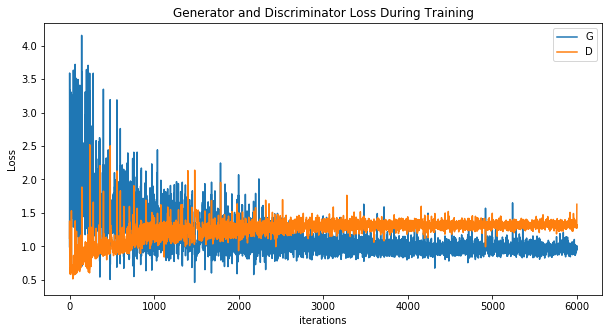

In [63]:
# Plot Loss history
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

We see that Initially, losses were extremely unstable and fluctuating, but they slowly converged and stabilized. Previously, D's loss hit almost 0 and G's loss grew consistently. Therefore, I added a dropout layer of 50% to the discriminator, and now its loss is larger than G's. Next, I would reduce the dropout layer to drop less (maybe 30%), but that might take another few training hours.

### Real versus Fake Images

View some real versus fake images




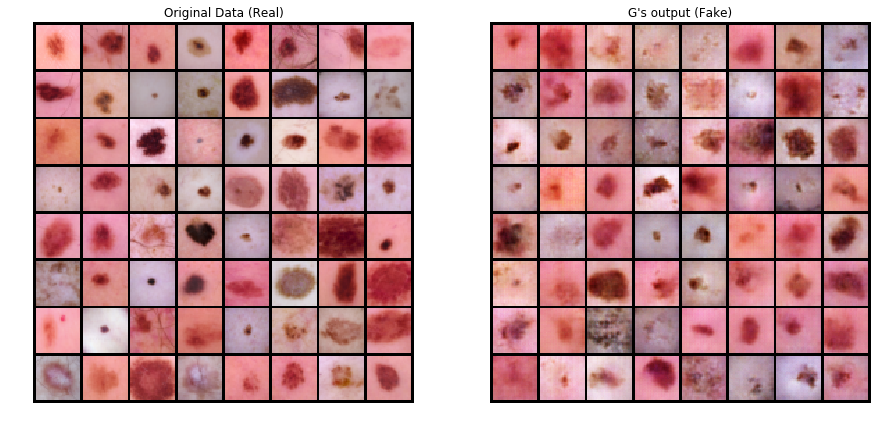

In [65]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
real_batch = next(iter(dataloader)) # get a batch of sample input images
show_images_grid(real_batch)

# Plot the fake images (generated through G at the last training epoch)
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images (G's output)")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Appendix

## Extra Unused Code Pieces
Just for saving for myself, and if interests the reader, here are some code pieces I wrote in the process and ended up not using.


In [46]:
### CUSTOM DATASET LOADER INTO PYTORCH

class SkinDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, images_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # get df:
        self.df = df
        # or load it yourself instead, change "df" parameter to csv_path
        # self.df = pd.read_csv(csv_path) # load csv as pandas dataframe
        # self.df['class'] = pd.Categorical(tile_df['dx']).codes
        self.root_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 1]) + '.jpg'
        image = io.imread(img_name)
        """
        For now we don't need the classes, but if we would –
        that's how we'd do it instead of the line below.
        For now, implemented a separate method for getting class label
        """
        # img_class = self.df.iloc[idx, 2]
        # sample = {'image': image, 'class': img_class}
        sample = image
        
        if self.transform:
            sample = self.transform(sample)

        return sample
    
    def __getclass___(self, idx):
        return self.df.iloc[idx, 2]

base_root = '/Volumes/GoogleDrive/My Drive/Colab Notebooks/'
csv_filepath = base_root + 'data/skincancer_ham/HAM10000_metadata.csv'
images_dirpath = base_root + 'data/skincancer_ham/skin_cancer/'
skindata = SkinDataset(df = df_images,
                       images_dir = images_dirpath,
                       transform = transforms.Compose([
                                    transforms.Resize(IMAGE_SIZE),
                                    transforms.CenterCrop(IMAGE_SIZE),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                    ]))

# Plot a training image
plt.imshow(skindata[0])
